In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [17]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [33]:
symbol = 'BTCUSDT'
start = int(datetime.datetime(2022,1,1).timestamp())
end = int(datetime.datetime(2022,12,2).timestamp())

In [35]:
wallex = f'https://api.wallex.ir/v1/udf/history?symbol={symbol}&resolution=60&from={start}&to={end}'
r= requests.get(wallex)
r

<Response [200]>

In [36]:
content = r.json()
content.keys()

dict_keys(['s', 't', 'c', 'o', 'h', 'l', 'v'])

In [37]:
btc_df = pd.DataFrame({'timestamp':content['t'],'open':content['o'],'close':content['c'],'low':content['l'],'high':content['h']})
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'], unit='s')

In [38]:
btc_df.set_index('timestamp', inplace=True)

In [39]:
btc_df['open'] = btc_df['open'].astype(float)
btc_df['close'] = btc_df['close'].astype(float)
btc_df['high'] = btc_df['high'].astype(float)
btc_df['low'] = btc_df['low'].astype(float)
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7895 entries, 2021-12-31 21:00:00 to 2022-12-01 20:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    7895 non-null   float64
 1   close   7895 non-null   float64
 2   low     7895 non-null   float64
 3   high    7895 non-null   float64
dtypes: float64(4)
memory usage: 308.4 KB


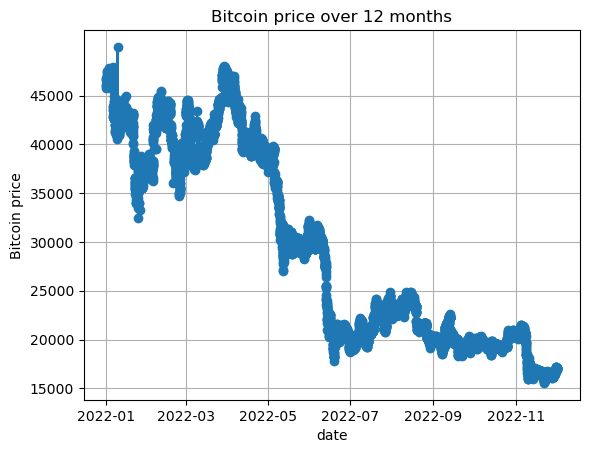

In [40]:
plt.plot(btc_df.index, btc_df['close'], marker='o')
plt.xlabel('date')
plt.ylabel('Bitcoin price')
plt.title('Bitcoin price over 12 months')
plt.yticks(np.arange(15000,50000,5000))
plt.grid()
plt.show()

calculating the first difference of the series by substracting the previous value from the current value. this can be done by pd.diff()

In [41]:
btc_df['diff'] = btc_df['close'].diff()
# btc_df['diff'] = btc_df['price']-btc_df['price'].shift(1)

In [42]:
result = adfuller(btc_df['diff'].dropna())
p_value = result[1]
p_value

2.33068831379395e-30

the p_value is less than 0.5 so the time series is stationary

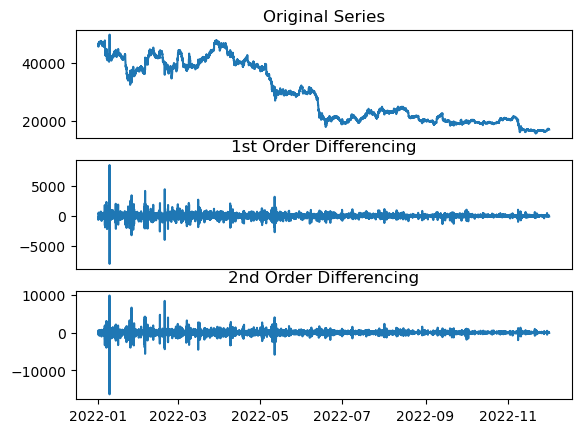

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(btc_df['close']); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
ax2.plot(btc_df['diff']); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
ax3.plot(btc_df['diff'].diff()); ax3.set_title('2nd Order Differencing')
plt.show()

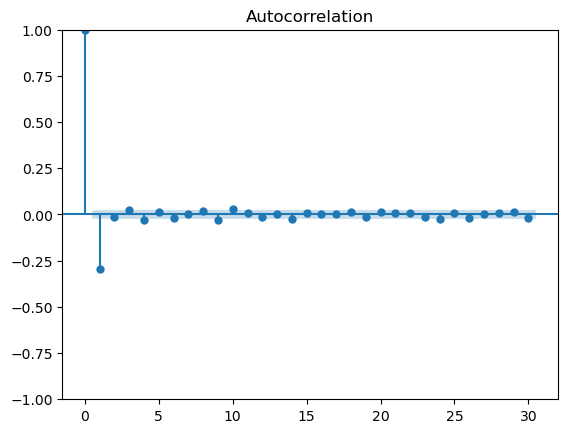

In [44]:
plot_acf(btc_df['diff'].dropna(),lags=30)
plt.show()

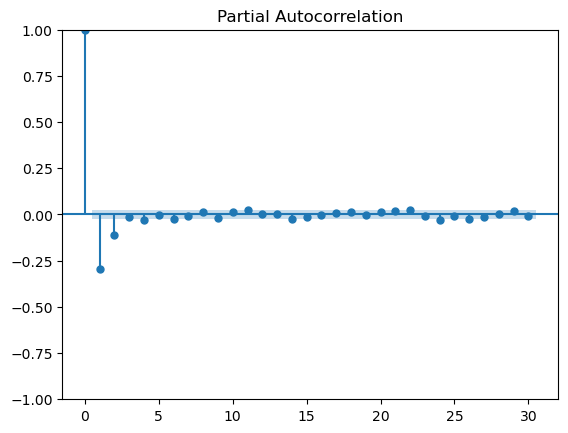

In [45]:
plot_pacf(btc_df['diff'].dropna(),lags=30)
plt.show()

for ARIMA model we need three parameters: p,d,q

p (AR order): the number of lag observations included in the model, can be determined by analyzing the partial AFC plot

d (integration order): the number of time series that needs to be differenced to make it stationary

q (MA order): the size of moving average window, can be determined by analyzing the partial AFC plot

by looking at the p_afc, we can see that the first lag is significantly out of the limit and the second one is also out of the significant limit but it is not that far so we can select the order of the p as 1. 

by looking at the afc, it is shown that 3 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 3. 

In [46]:
p = 1
d = 1
q = 3
arima_model = ARIMA(btc_df['close'],order=(p,d,q))
model_fit = arima_model.fit()
model_fit.summary()

E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 7895
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -56979.319
Date:                Mon, 09 Oct 2023   AIC                         113968.638
Time:                        18:11:12   BIC                         114003.507
Sample:                             0   HQIC                        113980.581
                               - 7895                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6344      0.141     -4.499      0.000      -0.911      -0.358
ma.L1          0.3085      0.142      2.170      0.030       0.030       0.587
ma.L2         -0.2221      0.046     -4.822      0.000      -0.312      -0.132
ma.L3          0.0131      0.007      1.884      0.060      -0.001       0.027
sigma2      1.087e+05    413.294    263.083      0.000    1.08e+05     1.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):           1504946.23
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             1.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
forecast = model_fit.forecast(steps = 3)
forecast

E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


7895    16944.059943
7896    16945.578977
7897    16943.484415
Name: predicted_mean, dtype: float64

In [48]:
actual_prices = btc_df['close'][-3:].to_numpy()
forecasted_prices = forecast
mae = mean_absolute_error(actual_prices, forecasted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, forecasted_prices))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 47.06516455981546
Root Mean Squared Error: 49.170765483067
